In [2]:
import tensorflow_datasets as tfds
from text_gan.data import Squad2
from text_gan.data.qgen_data import CONFIG
import tensorflow_text as text
import tensorflow as tf
import numpy as np
import pandas as pd
import ujson as json

In [2]:
data = tfds.load("squad2", data_dir="/tf/data/tf_data", split='validation')
tokenizer = text.UnicodeScriptTokenizer()
context = data.map(lambda x: tokenizer.tokenize(x['context']))
questions = data.map(lambda x: tokenizer.tokenize(x['question']))

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.
Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [3]:
df = pd.DataFrame({
    'clen': list(map(lambda x: len(x), context.as_numpy_iterator())),
    'qlen': list(map(lambda x: len(x), questions.as_numpy_iterator()))
})

In [9]:
df.describe(percentiles=[.25,.5,.75,.95])

,clen,qlen
count,11873.000000,11873.000000
mean,147.376569,11.352565
std,65.765919,3.696657
min,30.000000,3.000000
25%,107.000000,9.000000
50%,131.000000,11.000000
75%,169.000000,13.000000
95%,257.400000,18.000000
max,704.000000,35.000000


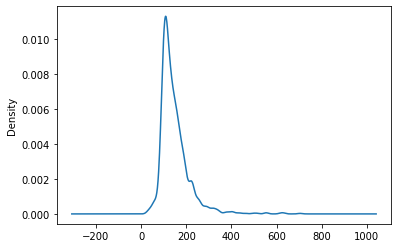

In [10]:
df.clen.plot.kde()

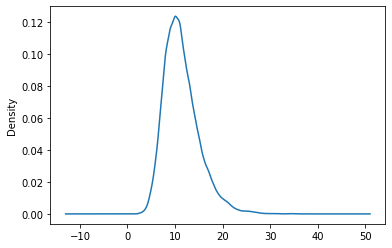

In [11]:
df.qlen.plot.kde()

In [3]:
qtokens = questions.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
qtokens

<DatasetV1Adapter shapes: (), types: tf.string>

In [4]:
qlist = list(qtokens.as_numpy_iterator())

In [5]:
words, counts = np.unique(qlist, return_counts=True)

In [6]:
words[:10], counts[:10]

(array([b'"', b'",', b'"10', b'"?', b'$', b'$10', b'$100,000?', b'$20',
        b'$300', b'$38,000'], dtype='|S19'),
 array([145,   1,   1,  36,   1,   1,   1,   2,   1,   2]))

In [7]:
counts.sum() == len(qlist)

True

In [8]:
df = pd.DataFrame({"Token": words, "Count": counts})
df.loc[:, 'Token'] = df.Token.map(lambda x: x.decode('utf-8'))
df = df.sort_values('Count', ascending=False)

In [9]:
word2idx = json.load(open(CONFIG.WORD2IDX, "r"))

In [10]:
df.dtypes

Token    object
Count     int64
dtype: object

In [11]:
df = df.reset_index(drop=True)
df.index = df.index + 1
df = df.reset_index()

In [12]:
df

,index,Token,Count
0,1,?,11058
1,2,the,8096
2,3,What,5809
3,4,of,4689
4,5,in,2846
...,...,...,...
11226,11227,measurment,1
11227,11228,Subcommittee,1
11228,11229,Subjects,1
11229,11230,Succeeding,1


In [13]:
qword2idx = dict(df.iloc[:4997,[1,0]].values)

In [14]:
len(qword2idx)

4997

In [15]:
qword2idx['<START>'] = 4998
qword2idx['<END>'] = 4999

In [22]:
len(np.unique(qword2idx.values())[0]) == len(qword2idx.values())

True

In [23]:
qword2idx

{'?': 1,
 'the': 2,
 'What': 3,
 'of': 4,
 'in': 5,
 'to': 6,
 'is': 7,
 'did': 8,
 'was': 9,
 'a': 10,
 'what': 11,
 'How': 12,
 "'": 13,
 'are': 14,
 'Who': 15,
 'and': 16,
 's': 17,
 'for': 18,
 'does': 19,
 'that': 20,
 'When': 21,
 ',': 22,
 'many': 23,
 'do': 24,
 'by': 25,
 'not': 26,
 '-': 27,
 'with': 28,
 'on': 29,
 'In': 30,
 'be': 31,
 'as': 32,
 'were': 33,
 'have': 34,
 'from': 35,
 'Where': 36,
 'an': 37,
 'year': 38,
 'type': 39,
 'Which': 40,
 'The': 41,
 'can': 42,
 'has': 43,
 'name': 44,
 'used': 45,
 'at': 46,
 'it': 47,
 'Rhine': 48,
 'which': 49,
 'first': 50,
 'one': 51,
 'when': 52,
 't': 53,
 'most': 54,
 'other': 55,
 'Why': 56,
 'oxygen': 57,
 'system': 58,
 'much': 59,
 'than': 60,
 'called': 61,
 'schools': 62,
 'between': 63,
 'people': 64,
 'into': 65,
 'how': 66,
 'French': 67,
 'two': 68,
 '.': 69,
 'there': 70,
 'Warsaw': 71,
 '"': 72,
 'kind': 73,
 'its': 74,
 'would': 75,
 'their': 76,
 'about': 77,
 'time': 78,
 'had': 79,
 'Amazon': 80,
 'use': 81

In [24]:
json.dump(qword2idx, open("/tf/data/squad/qword2idx.json", "w"))

In [26]:
df = tf.data.Dataset.from_tensor_slices([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
df = df.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
list(df.as_numpy_iterator())

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [10]:
dr = [[((1,[1]), 2), ((1,[1,2]), 3)], [((2,[3]), 4), ((2,[3,4]), 5)]]
def gen():
    for d in dr:
        for di in d:
            yield di
df = tf.data.Dataset.from_generator(gen, ((tf.int32,tf.int32), tf.int32), ((tf.TensorShape([]), tf.TensorShape([None])), tf.TensorShape([])))
# df = df.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
list(df.as_numpy_iterator())

[((1, array([1], dtype=int32)), 2),
 ((1, array([1, 2], dtype=int32)), 3),
 ((2, array([3], dtype=int32)), 4),
 ((2, array([3, 4], dtype=int32)), 5)]

In [12]:
df.batch(32)

<BatchDataset shapes: (((None,), (None, None)), (None,)), types: ((tf.int32, tf.int32), tf.int32)>

In [30]:
dr1 = [[1],[4],[7]]
dr12 = [[2,3], [5,6], [8,9]]
dr2 = [[1,2,3], [4,5,6], [7,8,9]]
df11 = tf.data.Dataset.from_tensor_slices(dr1)
df12 = tf.data.Dataset.from_tensor_slices(dr12)
df2 = tf.data.Dataset.from_tensor_slices(dr2)
df1 = tf.data.Dataset.zip((df11, df12))
df = tf.data.Dataset.zip((df1, df2))
df

<ZipDataset shapes: (((1,), (2,)), (3,)), types: ((tf.int32, tf.int32), tf.int32)>

In [31]:
list(df.as_numpy_iterator())

[((array([1], dtype=int32), array([2, 3], dtype=int32)),
  array([1, 2, 3], dtype=int32)),
 ((array([4], dtype=int32), array([5, 6], dtype=int32)),
  array([4, 5, 6], dtype=int32)),
 ((array([7], dtype=int32), array([8, 9], dtype=int32)),
  array([7, 8, 9], dtype=int32))]

In [76]:
def gen(d1, d2):
    d11, d12 = d1
    X1 = []
    X2 = []
    X3 = []
    y = []
    for i in range(1, d2.shape[0]):
        X1.append(d11)
        X2.append(d12)
        X3.append(d2[:i])
        y.append(d2[i])
    X1 = tf.data.Dataset.from_tensor_slices(X1)
    X2 = tf.data.Dataset.from_tensor_slices(X2)
    x3 = tf.data.Dataset.from_tensors(X3[0])
    for X3i in X3[1:]:
        x3 = x3.concatenate(tf.data.Dataset.from_tensors(X3i))
    # X3 = tf.data.Dataset.from_generator(lambda: X3, tf.int32, tf.TensorShape([None]))
    y = tf.data.Dataset.from_tensor_slices(y)
    X = tf.data.Dataset.zip((X1, X2))
    X = tf.data.Dataset.zip((X, x3))
    return tf.data.Dataset.zip((X, y))

dfd = df.flat_map(gen)

In [77]:
def mapper(X, y):
    X12, X3 = X
    X1, X2 = X12
    return ((X1, X2, X3), y)
dfd = dfd.map(mapper)
dfd

<MapDataset shapes: (((1,), (2,), (None,)), ()), types: ((tf.int32, tf.int32, tf.int32), tf.int32)>

In [78]:
list(dfd.as_numpy_iterator())

[((array([1], dtype=int32),
   array([2, 3], dtype=int32),
   array([1], dtype=int32)),
  2),
 ((array([1], dtype=int32),
   array([2, 3], dtype=int32),
   array([1, 2], dtype=int32)),
  3),
 ((array([4], dtype=int32),
   array([5, 6], dtype=int32),
   array([4], dtype=int32)),
  5),
 ((array([4], dtype=int32),
   array([5, 6], dtype=int32),
   array([4, 5], dtype=int32)),
  6),
 ((array([7], dtype=int32),
   array([8, 9], dtype=int32),
   array([7], dtype=int32)),
  8),
 ((array([7], dtype=int32),
   array([8, 9], dtype=int32),
   array([7, 8], dtype=int32)),
  9)]